# **Semantic Segmentation Using HAGDAVS Dataset**

### **Import Libraries**

In [1]:
!pip uninstall tensorflow -y



Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0


In [2]:
!pip uninstall tensorflow-io -y

Found existing installation: tensorflow-io 0.32.0
Uninstalling tensorflow-io-0.32.0:
  Successfully uninstalled tensorflow-io-0.32.0


In [3]:
!pip install tensorflow

  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)


In [4]:
!pip install --no-deps tensorflow-io

  Using cached tensorflow_io-0.32.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (28.0 MB)


In [5]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import pathlib
from PIL import Image
import shutil
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.data import AUTOTUNE

In [6]:
from typing import Callable
import tensorflow.keras.backend as K
def binary_tversky_coef(y_true: tf.Tensor, y_pred: tf.Tensor, beta: float, smooth: float = 1.) -> tf.Tensor:
    """
    Tversky coefficient is a generalization of the Dice's coefficient. It adds an extra weight (β) to false positives
    and false negatives:
        TC(p, p̂) = p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    When β=1/2, Tversky coefficient is equal to the Dice's coefficient:
        TL(p, p̂) = p*p̂/[p*p̂ + (1/2)*(1-p)*p̂ + (1-(1/2))*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p*(1-p̂)]
        = p*p̂/[p*p̂ + (1/2)*p̂ - (1/2)*p*p̂ + (1/2)*p - (1/2)*p*p̂)]
        = p*p̂/[p*p - p*p̂̂ + (1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*p̂ + (1/2)*p]
        = p*p̂/[(1/2)*(p̂+p)]
        = 2*p*p̂/(p̂+p)
    :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    :param beta: Weight coefficient (float)
    :param smooth: Smoothing factor (float, default = 1.)
    :return: Tversky coefficient (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>))
    """
    axis_to_reduce = range(1, K.ndim(y_pred))  # All axis but first (batch)
    numerator = K.sum(y_true * y_pred, axis=axis_to_reduce)  # p*p̂
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  # p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)
    denominator = K.sum(denominator, axis=axis_to_reduce)

    return (numerator + smooth) / (denominator + smooth)  # (p*p̂ + smooth)/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂) + smooth]


def convert_to_logits(y_pred: tf.Tensor) -> tf.Tensor:
    """
    Converting output of sigmoid to logits.
    :param y_pred: Predictions after sigmoid (<BATCH_SIZE>, shape=(None, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1)).
    :return: Logits (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
    """
    # To avoid unwanted behaviour of log operation
    y_pred = K.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    return K.log(y_pred / (1 - y_pred))


def binary_dice_coef_loss(smooth: float = 1.) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Dice coefficient loss:
        DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param smooth: Smoothing factor (float, default=1.)
    :return: Dice coefficient loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Dice loss (Tversky loss with β=0.5).
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Dice coefficient loss for each observation in batch (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1 - binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

    return loss


def binary_weighted_dice_crossentropy_loss(smooth: float = 1.,
                                           beta: float = 0.5) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted Dice cross entropy combination loss is a weighted combination between Dice's coefficient loss and
    binary cross entropy:
        DL(p, p̂) = 1 - (2*p*p̂+smooth)/(p+p̂+smooth)
        CE(p, p̂) = - [p*log(p̂ + 1e-7) + (1-p)*log(1-p̂ + 1e-7)]
        WDCE(p, p̂) = weight*DL + (1-weight)*CE
                   = weight*[1 - (2*p*p̂+smooth)/(p+p̂+smooth)] - (1-weight)*[p*log(p̂ + 1e-7) + (1-p)*log(1-p̂ + 1e-7)]
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param smooth: Smoothing factor (float, default=1.)
    :param beta: Loss weight coefficient (float, default=0.5)
    :return: Dice cross entropy combination loss (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    assert 0. <= beta <= 1., "Loss weight has to be between 0.0 and 1.0"

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Dice cross entropy combination loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Dice cross entropy combination loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        cross_entropy = K.binary_crossentropy(target=y_true, output=y_true)

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(cross_entropy))
        cross_entropy = K.mean(x=cross_entropy, axis=axis_to_reduce)

        dice_coefficient = binary_tversky_coef(y_true=y_true, y_pred=y_pred, beta=0.5, smooth=smooth)

        return beta*(1. - dice_coefficient) + (1. - beta)*cross_entropy

    return loss


def binary_tversky_loss(beta: float) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Tversky loss:
        TL(p, p̂) = 1 - p*p̂/[p*p̂ + β*(1-p)*p̂ + (1-β)*p*(1-p̂)]
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :return: Tversky loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute the Tversky loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Tversky loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        return 1-binary_tversky_coef(y_true, y_pred, beta=beta)

    return loss


def binary_weighted_cross_entropy(beta: float, is_logits: bool = False) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted cross entropy. All positive examples get weighted by the coefficient beta:
        WCE(p, p̂) = −[β*p*log(p̂) + (1−p)*log(1−p̂)]
    To decrease the number of false negatives, set β>1. To decrease the number of false positives, set β<1.
    If last layer of network is a sigmoid function, y_pred needs to be reversed into logits before computing the
    weighted cross entropy. To do this, we're using the same method as implemented in Keras binary_crossentropy:
    https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :param is_logits: If y_pred are logits (bool, default=False)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        if not is_logits:
            y_pred = convert_to_logits(y_pred)

        wce_loss = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=beta)

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return wce_loss

    return loss


def binary_balanced_cross_entropy(beta: float, is_logits: bool = False) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Balanced cross entropy. Similar to weighted cross entropy (see weighted_cross_entropy),
    but both positive and negative examples get weighted:
        BCE(p, p̂) = −[β*p*log(p̂) + (1-β)*(1−p)*log(1−p̂)]
    If last layer of network is a sigmoid function, y_pred needs to be reversed into logits before computing the
    balanced cross entropy. To do this, we're using the same method as implemented in Keras binary_crossentropy:
    https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :param is_logits: If y_pred are logits (bool, default=False)
    :return: Balanced cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if beta == 1.:  # To avoid division by zero
        beta -= tf.keras.backend.epsilon()

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the balanced cross entropy in the following way:
            BCE(p, p̂) = −[(β/(1-β))*p*log(p̂) + (1−p)*log(1−p̂)]*(1-β) = −[β*p*log(p̂) + (1-β)*(1−p)*log(1−p̂)]
        :param y_true: Ground truth (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Balanced cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        if not is_logits:
            y_pred = convert_to_logits(y_pred)

        pos_weight = beta / (1 - beta)
        bce_loss = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=pos_weight)
        bce_loss = bce_loss * (1 - beta)

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(bce_loss))
        bce_loss = K.mean(bce_loss, axis=axis_to_reduce)

        return bce_loss

    return loss


def binary_focal_loss(beta: float, gamma: float = 2.) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Focal loss is derived from balanced cross entropy, where focal loss adds an extra focus on hard examples in the
    dataset:
        FL(p, p̂) = −[β*(1-p̂)ᵞ*p*log(p̂) + (1-β)*p̂ᵞ*(1−p)*log(1−p̂)]
    When γ = 0, we obtain balanced cross entropy.
    Paper: https://arxiv.org/pdf/1708.02002.pdf
    Used as loss function for binary image segmentation with one-hot encoded masks.
    :param beta: Weight coefficient (float)
    :param gamma: Focusing parameter, γ ≥ 0 (float, default=2.)
    :return: Focal loss (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the focal loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, 1))
        :return: Focal loss (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        f_loss = beta * (1 - y_pred) ** gamma * y_true * K.log(y_pred)  # β*(1-p̂)ᵞ*p*log(p̂)
        f_loss += (1 - beta) * y_pred ** gamma * (1 - y_true) * K.log(1 - y_pred)  # (1-β)*p̂ᵞ*(1−p)*log(1−p̂)
        f_loss = -f_loss  # −[β*(1-p̂)ᵞ*p*log(p̂) + (1-β)*p̂ᵞ*(1−p)*log(1−p̂)]

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(f_loss))
        f_loss = K.mean(f_loss, axis=axis_to_reduce)

        return f_loss

    return loss

## **Load Data**

This code performs the following actions:

1. Defines directory paths for the input data, including the folder containing RGB images and the folder containing masks.
2. Sets the destination folder path to save the modified images.
3. Creates the new destination folder if it doesn't exist.
4. Retrieves the list of file names in the masks folder.
5. Iterates over each file in the list and does the following:
   - Checks if the file name contains the text "MClass".
   - If it does, modifies the file name by replacing "MClass" with "RGB".
   - Creates an old file path and a new file path.
   - Copies the old file to the new path.

In summary, the code takes masks in the "MClass" format and copies them to a new folder, but changes their names to the "RGB" format.

In [7]:
data_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS')
images_dir = data_dir / 'RGB'
masks_dir = data_dir / 'MASK'

folder_path = masks_dir  # Ruta de la carpeta que contiene las imágenes
new_folder_path = '/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS/MASK'

# Crear la nueva carpeta si no existe
os.makedirs(new_folder_path, exist_ok=True)

# Obtener la lista de nombres de archivo en la carpeta
file_list = os.listdir(folder_path)

# Aplicar la modificación del nombre y crear nuevos archivos en la nueva carpeta
for filename in file_list:
    if "MClass" in filename:
        new_filename = filename.replace("MClass", "RGB")
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(new_folder_path, new_filename)
        shutil.copy2(old_path, new_path)

This code performs the following actions:

1. Defines directory paths for the image and mask folders.
2. Retrieves a list of file paths for the images and masks.
3. Creates empty lists to store image and mask patches.
4. Sets the desired patch size.
5. Defines a function to load and split the images and masks into patches.
   - It reads the image and mask files.
   - Removes the alpha channel from the images and masks.
   - Divides the image into patches based on the specified patch size.
   - Checks if all pixels in a mask patch are black, and if so, skips it.
   - Appends the image and mask patches to their respective lists.
6. Applies the load_and_split_patches function to each image and mask pair.
7. Converts the lists of patches into TensorFlow tensors.
8. Creates a dataset from the image and mask patches.

In summary, the code loads image and mask files, divides them into patches of a specified size, filters out patches with all-black masks, and creates a dataset for further processing or training.

In [8]:


# Ruta a las carpetas de imágenes y máscaras
ima_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS')
images_dir = ima_dir / 'RGB'
m_dir = pathlib.Path('/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS')
mask_dir = m_dir / 'MASK'

# Obtener una lista de rutas de archivo para imágenes y máscaras
image_paths = sorted([str(path) for path in images_dir.glob('*.tif')])
mask_paths = sorted([str(path) for path in mask_dir.glob('*.tif')])

# Crear una lista para almacenar los parches de imágenes y máscaras
image_patches = []
mask_patches = []

# Tamaño del parche deseado
patch_size = (256, 256)


# Definir una función para cargar y dividir las imágenes y máscaras en parches
def load_and_split_patches(image_path, mask_path):
    image = tfio.experimental.image.decode_tiff(tf.io.read_file(image_path))
    mask = tfio.experimental.image.decode_tiff(tf.io.read_file(mask_path))

    # Eliminar el canal alfa de las imágenes y máscaras
    image = image[:, :, :3]
    mask = mask[:, :, :3]

    # Dividir la imagen en parches
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch_image = image[i:i+patch_size[0], j:j+patch_size[1], :]
            patch_mask = mask[i:i+patch_size[0], j:j+patch_size[1], :]

            # Verificar si todos los píxeles en el parche de la máscara son negros
            if tf.reduce_all(tf.math.equal(patch_mask, [0, 0, 0])):
                continue
                
            #patch_mask = convertir_colores(patch_mask)
            image_patches.append(patch_image)
            mask_patches.append(patch_mask)

    return None

# Aplicar la función de carga y división de parches a cada par de rutas de archivo
for image_path, mask_path in zip(image_paths, mask_paths):
    load_and_split_patches(image_path, mask_path)

# Convertir las listas de parches en tensores
image_patches = tf.convert_to_tensor(image_patches)
mask_patches = tf.convert_to_tensor(mask_patches)

# Crear un dataset a partir de los parches de imágenes y máscaras
dataset = tf.data.Dataset.from_tensor_slices((image_patches, mask_patches))

The size of images in dataset:

In [9]:
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None))>

## **Display Data**

Function for show the image, mask and prediction mask

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

## **Using only one class**

This code defines a function called `convertir_mascara` and applies it to a dataset using the `map` function.

The `convertir_mascara` function performs the following actions:

1. Casts the input mask tensor to `float32` data type.
2. Creates a new mask tensor filled with zeros, with dimensions `(256, 256, 1)`.
3. Assigns values corresponding to each class in the mask:
   - If all RGB values in the mask are `[0, 0, 0]`, assigns `0.0` to the corresponding pixel in the converted mask.
   - If all RGB values are `[255, 0, 0]`, assigns `0.0`.
   - If all RGB values are `[0, 255, 0]`, assigns `1.0`.
   - If all RGB values are `[0, 0, 255]`, assigns `0.0`.
4. Returns the converted mask.

The code then applies the `convertir_mascara` function to each element in the `dataset` using the `map` function. The `map` function takes a lambda function that applies the conversion function to each `(image, mask)` pair in the dataset, resulting in a new dataset named `mapped_dataset`. The images in the dataset remain unchanged, while the masks are converted using the `convertir_mascara` function.

In [11]:
def convertir_mascara(mascara):
    mascara = tf.cast(mascara, dtype=tf.float32)
    mascara_convertida = tf.zeros((256, 256, 1), dtype=tf.float32)

    # Asigna valores correspondientes a cada clase
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [255, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 255, 0]), axis=-1, keepdims=True), 0.9, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 255]), axis=-1, keepdims=True), 0.0, mascara_convertida)

    return mascara_convertida

mapped_dataset = dataset.map(lambda x, y: (x, convertir_mascara(y)))

This code defines a function called `filter_func` that filters the `mapped_dataset` based on certain criteria using the `filter` function.

The `filter_func` function performs the following actions:

1. Reshapes the mask tensor into a 1-dimensional tensor.
2. Uses `tf.unique` to obtain the unique classes present in the mask.
3. Checks if the number of unique classes (`tf.size(unique_classes)`) is greater than or equal to 2.
   - If there are two or more unique classes, it returns `True`, indicating that the image and mask pair should be included in the filtered dataset.
   - If there are fewer than two unique classes, it returns `False`, indicating that the image and mask pair should be filtered out.

The code then applies the `filter_func` function to each element in the `mapped_dataset` using the `filter` function. The `filter` function takes the lambda function `filter_func` as an argument and returns a new dataset named `filtered_dataset` that contains only the image and mask pairs that satisfy the filtering criteria.

In [12]:


def filter_func(image, mask):
    unique_classes = tf.unique(tf.reshape(mask, [-1]))[0]
    return tf.size(unique_classes) >= 2

filtered_dataset = mapped_dataset.filter(filter_func)

dataset_length = 0
for _ in filtered_dataset:
    dataset_length += 1

print("Longitud aproximada del dataset filtrado:", dataset_length)

Longitud aproximada del dataset filtrado: 1043


## **Splitting data**

train/test/val split

In [13]:
# dividir el dataset en conjuntos de entrenamiento, validación y prueba
total_samples = (dataset_length)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset = filtered_dataset.take(train_size)
val_dataset = filtered_dataset.skip(train_size).take(val_size)
test_dataset = filtered_dataset.skip(train_size + val_size).take(test_size)

In [14]:
BATCH_SIZE = 16
BUFFER_SIZE = 100

In [15]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

## **Unet**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
    
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dropout
    x = layers.Dropout(0.2)(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.2)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.2)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x
    
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,3))
    
    #Data augmentation
    a1 = data_augmentation(inputs)

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(a1, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    bottleneck = layers.Dropout(0.3)(bottleneck)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

loss = binary_weighted_dice_crossentropy_loss()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=loss,
                   metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [20]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['sequential[0][0]']             
                                )                                                                 
                                                                                              

## **Training**

In [21]:
keras.backend.clear_session()
NUM_EPOCHS = 50
BATCH_SIZE = 16


STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,)

Epoch 1/50


2023-06-29 02:29:05.568843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - 193s 2s/step - loss: 0.4719 - mean_io_u: 0.4954 - val_loss: 0.4667 - val_mean_io_u: 0.0000e+00
Epoch 2/50
65/65 [==============================] - 122s 2s/step - loss: 0.4671 - mean_io_u: 0.4956 - val_loss: 0.4667 - val_mean_io_u: 0.0012
Epoch 3/50
65/65 [==============================] - 119s 2s/step - loss: 0.4689 - mean_io_u: 0.4993 - val_loss: 0.4231 - val_mean_io_u: 0.2975
Epoch 4/50
65/65 [==============================] - 120s 2s/step - loss: 0.4664 - mean_io_u: 0.4992 - val_loss: 0.4657 - val_mean_io_u: 0.2906
Epoch 5/50
65/65 [==============================] - 118s 2s/step - loss: 0.4620 - mean_io_u: 0.4987 - val_loss: 0.4656 - val_mean_io_u: 0.0240
Epoch 6/50
65/65 [==============================] - 119s 2s/step - loss: 0.4677 - mean_io_u: 0.4949 - val_loss: 0.4539 - val_mean_io_u: 0.3801
Epoch 7/50
65/65 [==============================] - 119s 2s/step - loss: 0.4631 - mean_io_u: 0.4960 - val_loss: 0.4636 - val_mean_io_u: 0.0563
Epoch 

## **Visualization of predictions**

In [22]:
def create_mask(pred_mask, threshold=0.2):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset, model, num):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 674ms/step


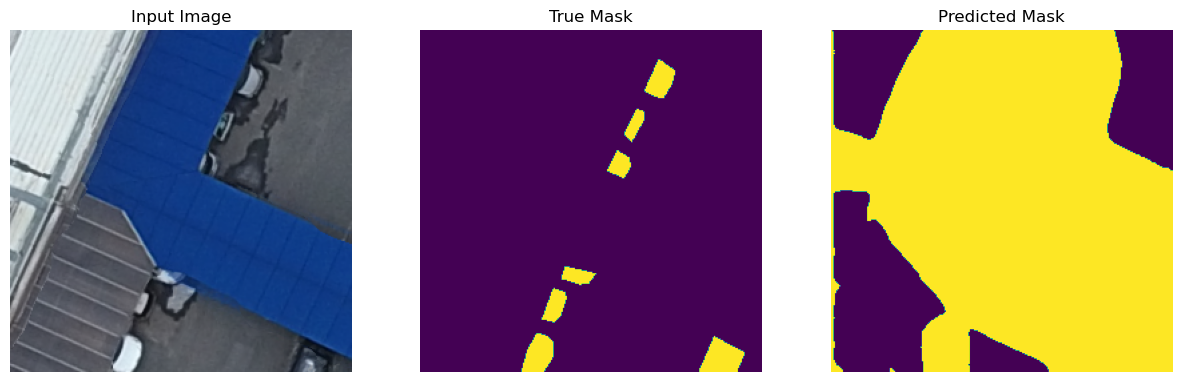

1/1 [==============================] - 0s 40ms/step


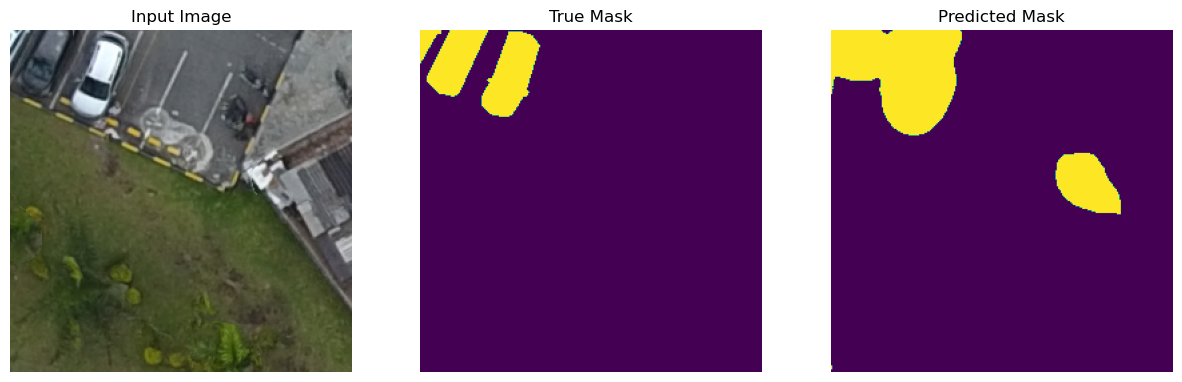

1/1 [==============================] - 0s 37ms/step


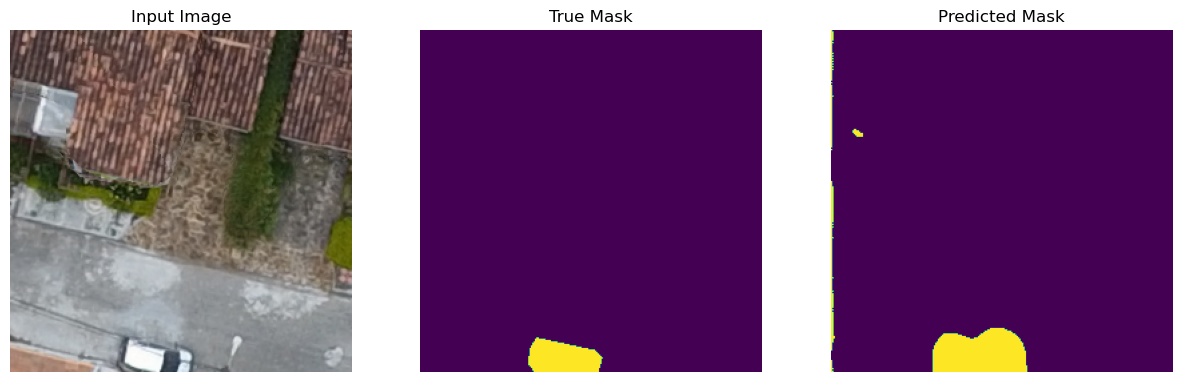

1/1 [==============================] - 0s 36ms/step


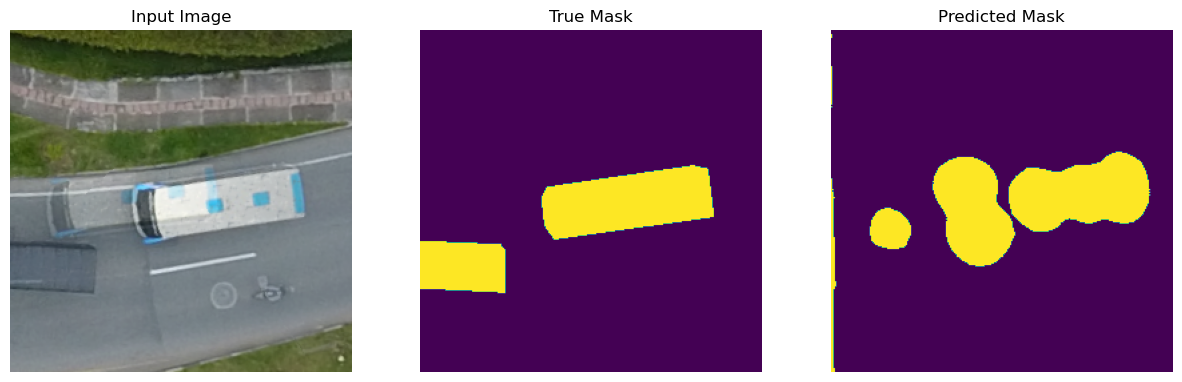

1/1 [==============================] - 0s 45ms/step


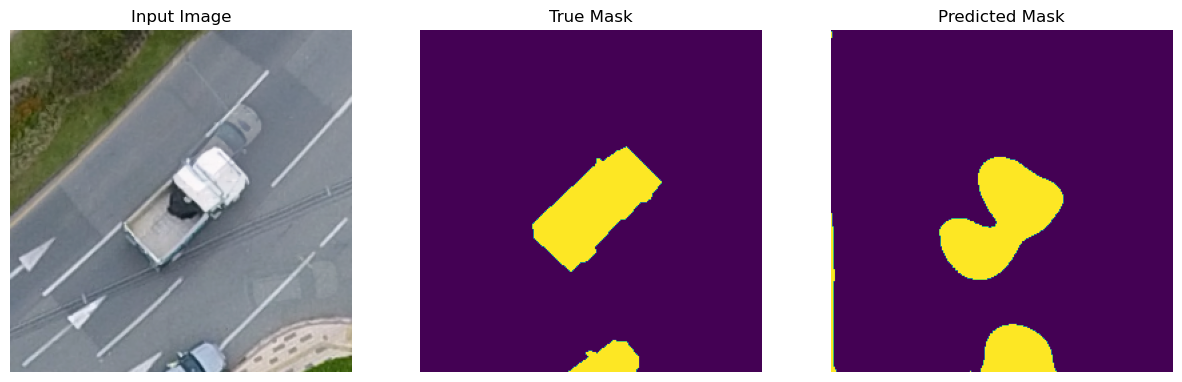

1/1 [==============================] - 0s 35ms/step


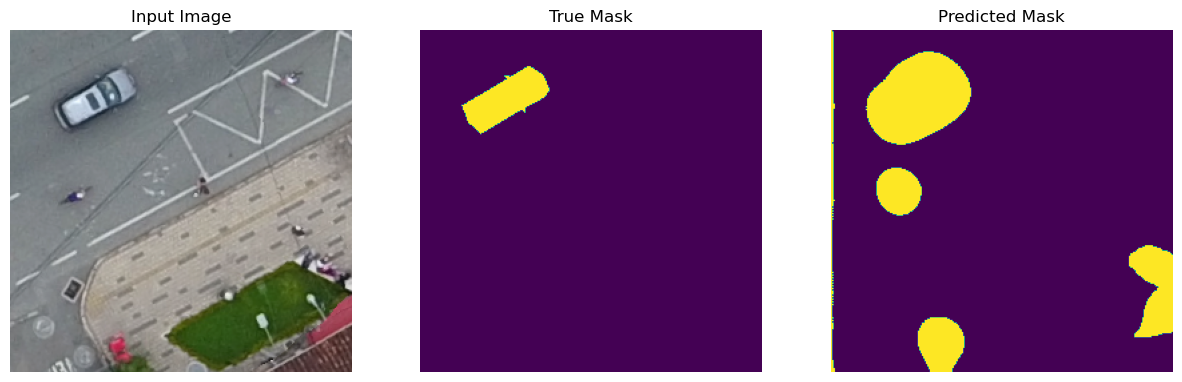

1/1 [==============================] - 0s 39ms/step


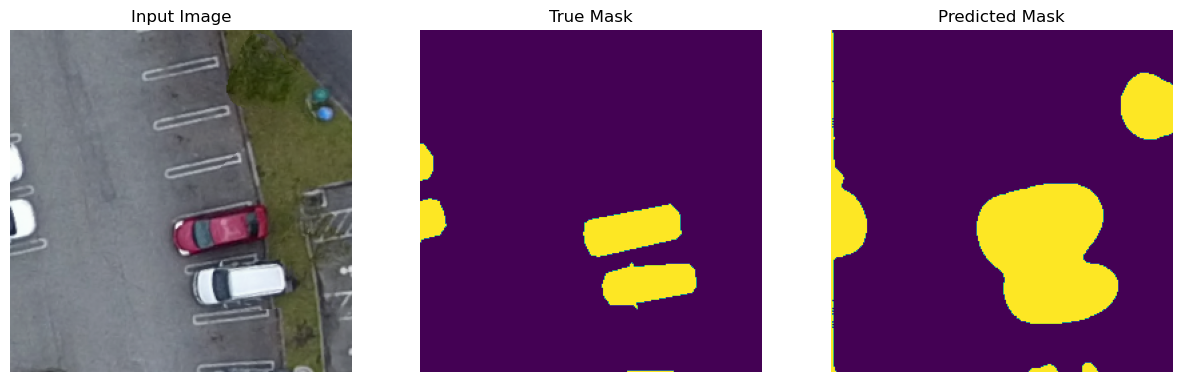

1/1 [==============================] - 0s 37ms/step


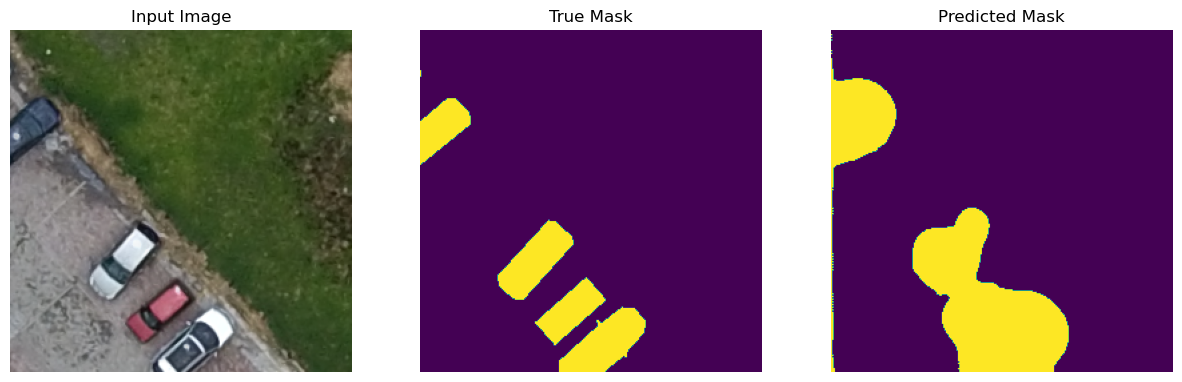

1/1 [==============================] - 0s 84ms/step


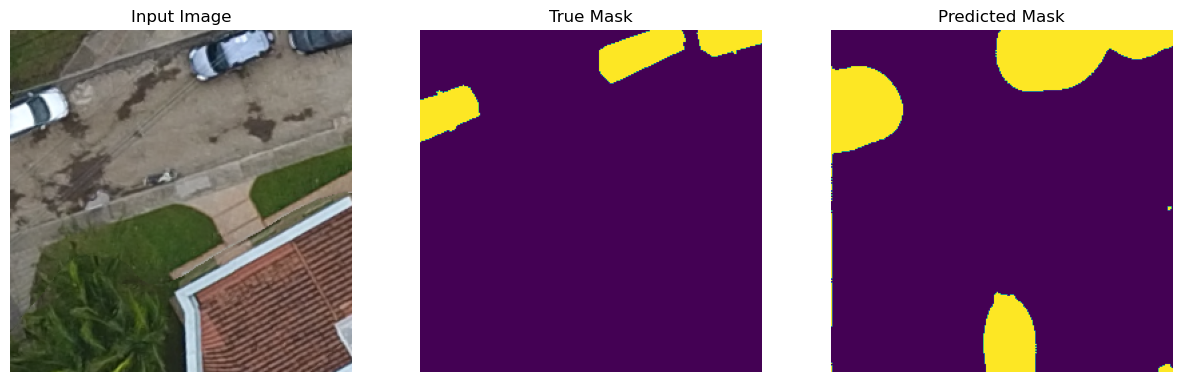

1/1 [==============================] - 7s 7s/step


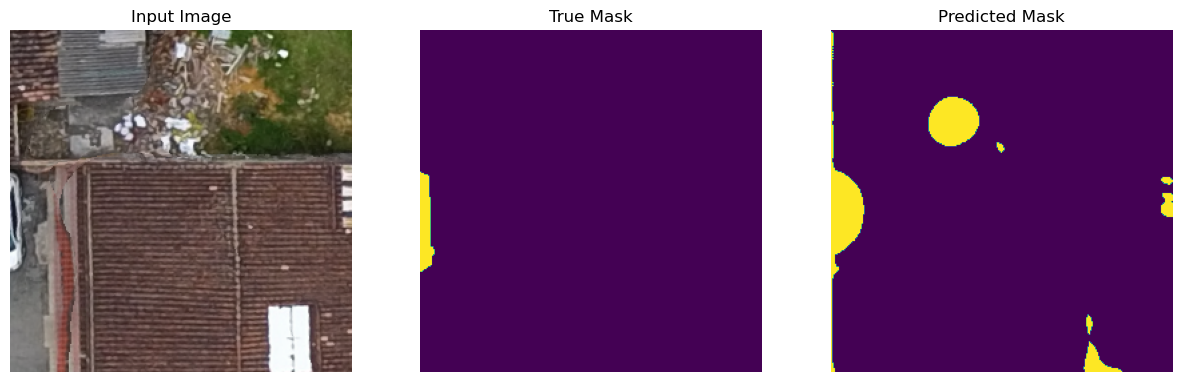

In [23]:
show_predictions(test_batches, unet_model, 16)

# VGG

In [24]:
from tensorflow.keras.applications import VGG16

In [25]:
def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
 
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
 
    return x

def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
 
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = layers.Input(input_shape)
 
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
 
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
 
    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)
 
    """ Decoder """
    d1 = decoder_block(b1, s4, 256)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 128)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 64)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 32)                      ## (512 x 512)
 
    """ Output """
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
 
    model = keras.Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [26]:
input_shape = (256, 256, 3)
model_v = build_vgg16_unet(input_shape)

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=False)

model_v.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=loss,
                   metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [32]:
keras.backend.clear_session()
NUM_EPOCHS = 10
BATCH_SIZE = 16


STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

model_v_history = model_v.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,)

Epoch 1/10
65/65 [==============================] - 63s 781ms/step - loss: 0.0486 - mean_io_u: 1.0000 - val_loss: 0.2773 - val_mean_io_u: 1.0000
Epoch 2/10
65/65 [==============================] - 41s 630ms/step - loss: 0.0246 - mean_io_u: 1.0000 - val_loss: 0.0403 - val_mean_io_u: 1.0000
Epoch 3/10
65/65 [==============================] - 40s 621ms/step - loss: 0.0199 - mean_io_u: 1.0000 - val_loss: 0.2883 - val_mean_io_u: 1.0000
Epoch 4/10
65/65 [==============================] - 40s 624ms/step - loss: 0.0165 - mean_io_u: 1.0000 - val_loss: 0.0339 - val_mean_io_u: 1.0000
Epoch 5/10
65/65 [==============================] - 41s 633ms/step - loss: 0.0161 - mean_io_u: 1.0000 - val_loss: 0.0439 - val_mean_io_u: 1.0000
Epoch 6/10
65/65 [==============================] - 40s 625ms/step - loss: 0.0138 - mean_io_u: 1.0000 - val_loss: 0.0240 - val_mean_io_u: 1.0000
Epoch 7/10
65/65 [==============================] - 40s 622ms/step - loss: 0.0138 - mean_io_u: 1.0000 - val_loss: 0.0150 - val_mea

1/1 [==============================] - 0s 403ms/step


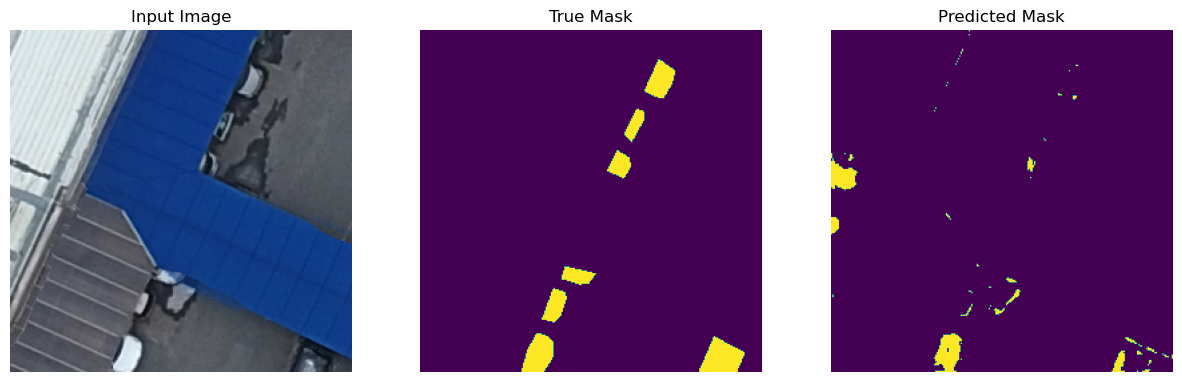

1/1 [==============================] - 0s 41ms/step


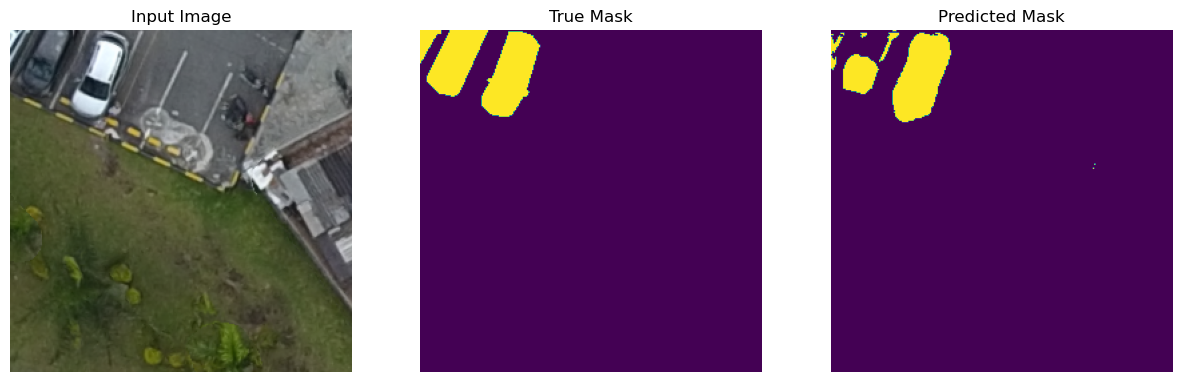

1/1 [==============================] - 0s 32ms/step


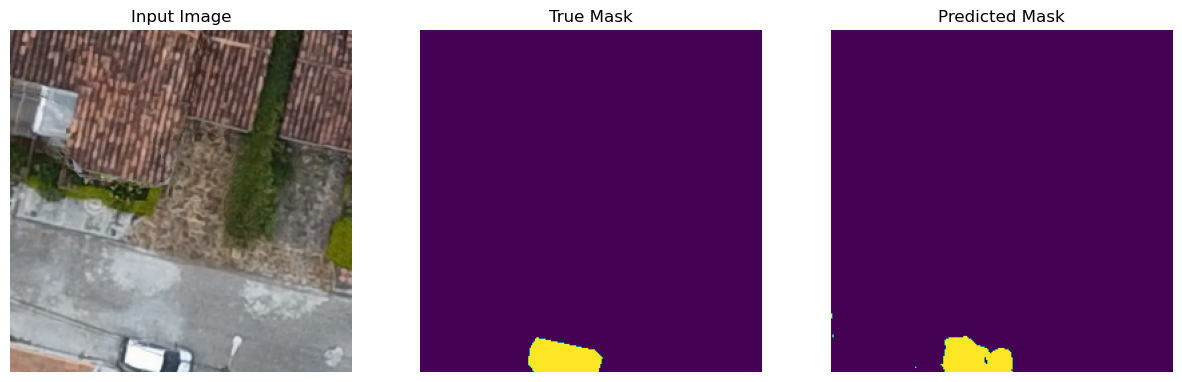

1/1 [==============================] - 0s 32ms/step


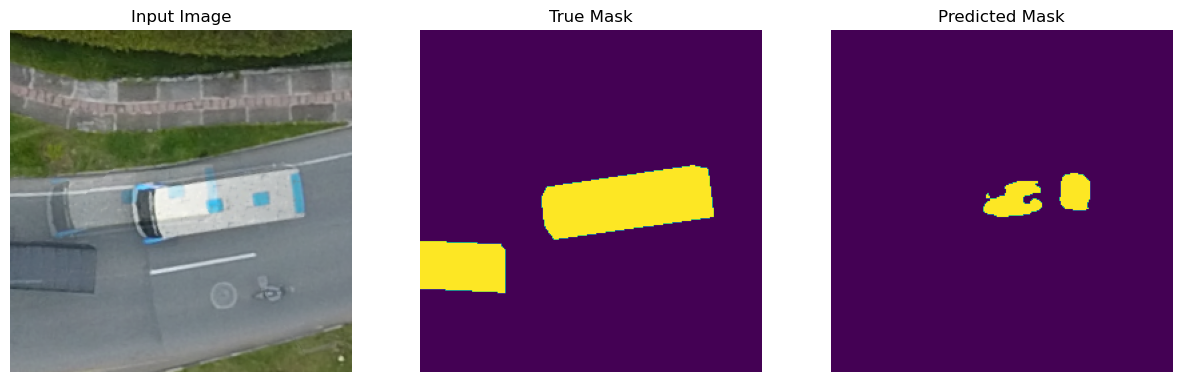

1/1 [==============================] - 0s 42ms/step


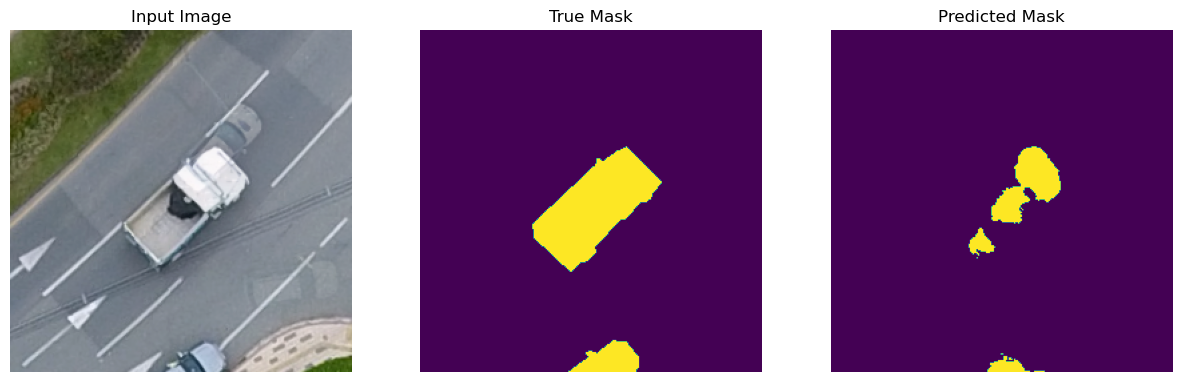

1/1 [==============================] - 0s 43ms/step


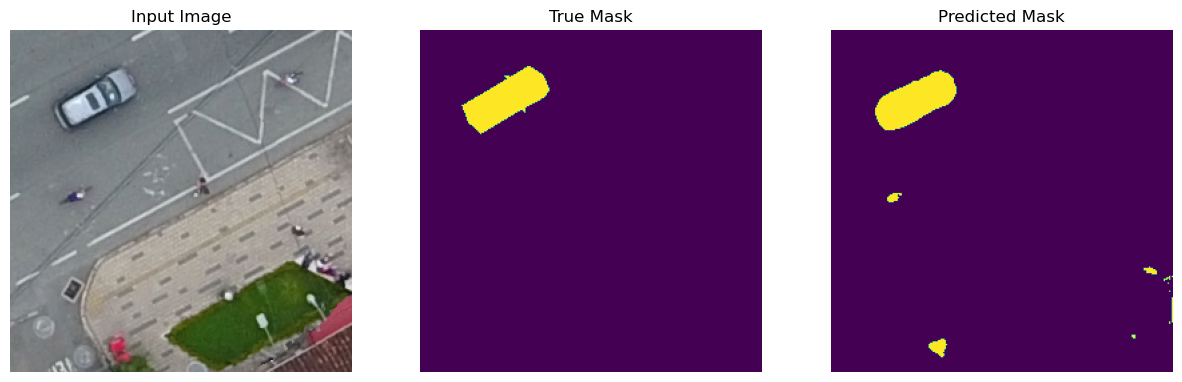

1/1 [==============================] - 0s 37ms/step


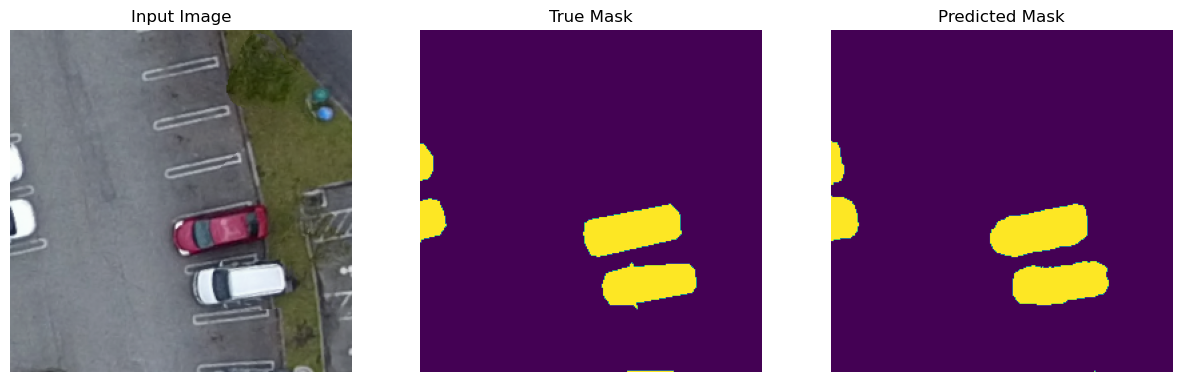

1/1 [==============================] - 0s 33ms/step


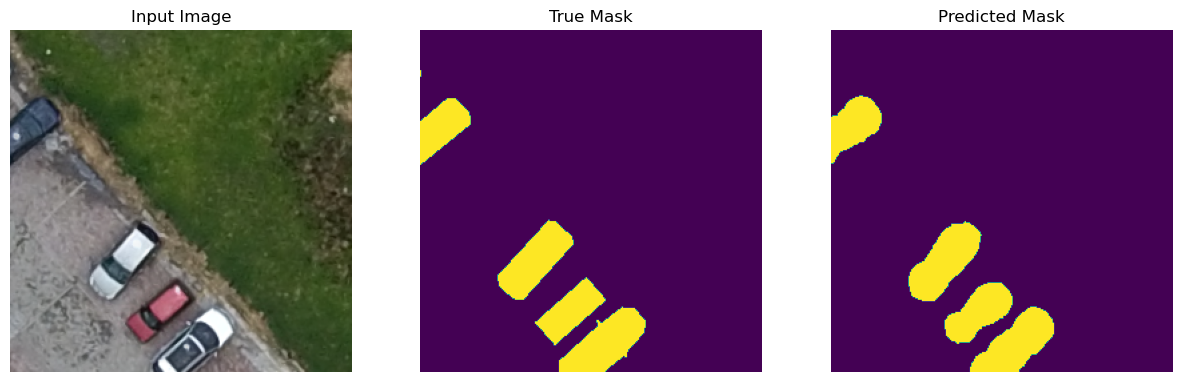

1/1 [==============================] - 0s 33ms/step


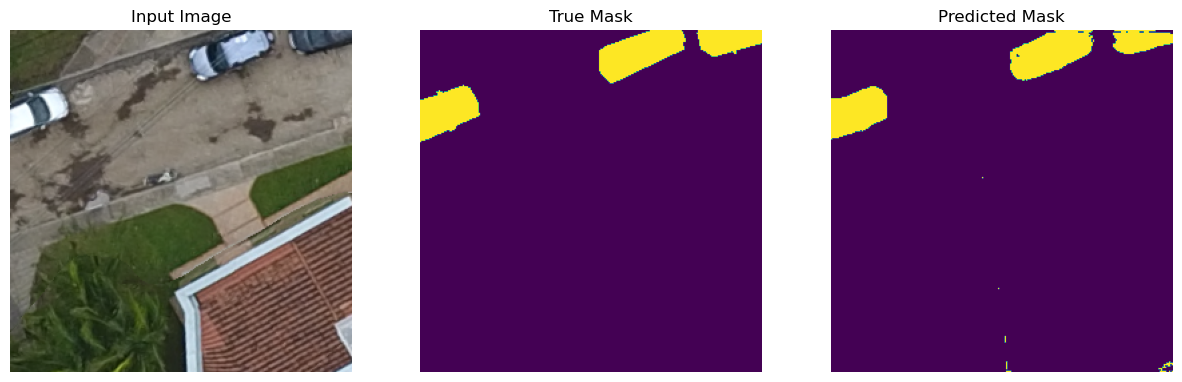

1/1 [==============================] - 6s 6s/step


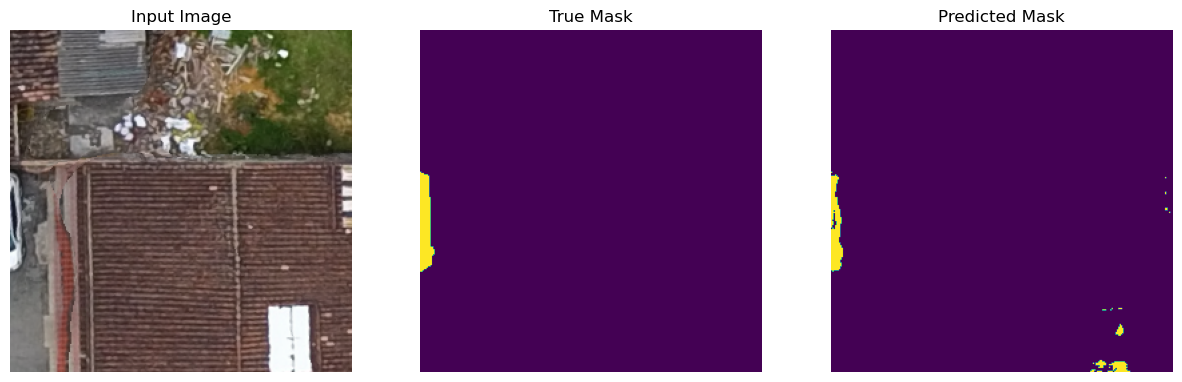

In [33]:
show_predictions(test_batches, model_v, 16)